### Adapt dataset to allow LVIS loss and mAP calculations

`__getitem__()` currently outputs tuple of:  
* `idx` 
* 'img' - tensor of shape (N, C, H, W)
* `y` (or 'target') which is a dict with keys:
    * 

In [1]:
import sys 
sys.path.append('../')

In [2]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

/Users/alexxcollins/miniforge3/envs/deep/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/Users/alexxcollins/Library/CloudStorage/OneDrive-City,UniversityofLondon/modules/computer_vision/coursework/INM706_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

pick an easier problem:
<br> sofa	414	528	f
<br> signboard	398	1799	


https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [ ]:
with open()

In [28]:
data_args = {'stage': 'val',
            'classes': ['cowboy_hat'],#  [cowboy_hat, coffee_maker, monkey, cappuccino, drumstick, chess_board] , 'sofa', 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
            'height': 1024,
            'width': 1024,
            'max_negative': 50}
val_data = dataset_lvis.LVISData(**data_args)

loaded 41 positive set images
loaded 50 negative set images
loaded 2 non-exhaustive set images
Loaded 89 images!
79 annotations found!
classes : {1: 'cowboy_hat'}
stage:  val
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  ../Datasets/coco/images/train2017


In [29]:
data_args = {'stage': 'train',
            'classes': ['cowboy_hat', 'coffee_maker', 'monkey', 'cappuccino', 'drumstick', 'chess_board'],# , 'sofa', 'signboard'],
            'ds_path' : "../Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
            'height': 1024,
            'width': 1024,
            'max_negative': 150}
train_data = dataset_lvis.LVISData(**data_args)

loaded 609 positive set images
loaded 150 negative set images
loaded 25 non-exhaustive set images
Loaded 731 images!
982 annotations found!
classes : {1: 'cappuccino', 2: 'coffee_maker', 3: 'cowboy_hat', 4: 'drumstick', 5: 'monkey'}
stage:  train
ds_path:  ../Datasets/coco/
labels_f:  ../Datasets/coco/annotations/lvis_v1_train.json
imgs_dir:  ../Datasets/coco/images/train2017


In [6]:
s = set((1,2,3,4,5))
3 in s

True

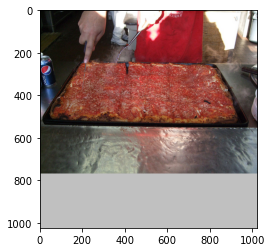

In [7]:
val_data.plot_img(1)

In [8]:
import ujson
fpath = Path('../Datasets/coco/annotations/lvis_v1_train.json') 
with open(fpath, "r") as f:
    data = ujson.load(f)

In [9]:
import ujson
fpathv = Path('../Datasets/coco/annotations/lvis_v1_val.json') 
with open(fpath, "r") as f:
    datav = ujson.load(f)

In [10]:
for k, v in data['annotations'][0].items():
    print(k)
print(data['annotations'][0]['image_id'])

bbox
category_id
image_id
id
segmentation
area
432732


In [11]:
for k, v in data.items():
    print(k)
    
len(data['images']), len(data['annotations'])
data['images'][0]

info
annotations
images
licenses
categories


{'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895,
 'neg_category_ids': [475,
  322,
  1024,
  412,
  256,
  966,
  98,
  131,
  1111,
  992,
  443,
  212,
  16,
  1067],
 'not_exhaustive_category_ids': [],
 'width': 640,
 'license': 3,
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'date_captured': '2013-11-14 11:18:45',
 'height': 360}

# Fine-tuning the model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [13]:
class CollateCustom:
    
    def __init__(self, batch_first=True):
        #self.pad_val = pad_value
        self.batch_first = batch_first
    
    def __call__(self, batch):
        
        idxs = [item[0] for item in batch]
        
        X = [item[1].unsqueeze(0) for item in batch]
        X = torch.cat(X, dim = 0)
        
        y = [item[2] for item in batch]
        #y = pad_sequence(y, batch_first=self.batch_first, padding_value=self.pad_val)
        
        return idxs, X, y
    

In [14]:
#Split dataset to test and train
indices = torch.randperm(len(val_data)).tolist()


dataset_train = torch.utils.data.Subset(val_data, indices[:300])
dataset_test = torch.utils.data.Subset(val_data, indices[300:330])


train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=CollateCustom())



In [15]:
len(dataset_train), len(dataset_test)

(300, 30)

In [16]:
dl1 = next(iter(test_loader))
# for v in dl1:
#     display(v)

# for k in dl1[2]:
#     display(k)
    
# display(dl1[1].shape)

dl1[2][0]['masks'].shape

dl1[2][0]['boxes'].shape

torch.Size([1, 4])

In [17]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /Users/alexxcollins/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [00:04<00:00, 43.6MB/s]


In [18]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 


num_epochs = 10
time_start = time.time() 


loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
#batch_loss = 0 

for epoch in range(num_epochs):
    model.train()
    
    #reset loss 
    batch_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_mask = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        #save losses 
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_mask += loss_dict['loss_mask'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() 
        
        losses = sum(loss for loss in loss_dict.values())
        batch_loss  += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    avg_batch_loss = batch_loss/(batch_num + 1) 
    
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [loss_classifier/(batch_num+1)],
          'loss_box_reg' : [loss_box_reg/(batch_num+1)],
           'loss_mask': [loss_mask/(batch_num+1)],
           'loss_objectness': [loss_objectness/(batch_num+1)],
           'loss_rpn_box_reg': [loss_rpn_box_reg/(batch_num+1)],
            'total_loss': avg_batch_loss 
          })     

    loss_df = pd.concat([loss_df, row], ignore_index = True, axis = 0)
    

    print(f"Loss after {epoch} epochs: {avg_batch_loss}")
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")
        
        
        
        


TypeError: 'NoneType' object is not iterable

In [ ]:
loss_df

# Plot loss 

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

sns.lineplot(data=loss_df, x="epoch", y="total_loss")


# Test cases

In [ ]:
idx, X, y = next(iter(test_loader))
model.eval() 
None
print(idx[0])

#val_data.plot_img(idx[0])
val_data.plot_img_with_ann(idx[0], bboxes = True)

In [ ]:
y_pred = model(X.to(device))
y_pred

(640, 496)


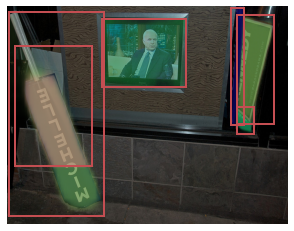

In [133]:
plot_predictions(idx[0], y_pred)